# Retrieve Weather Data

This notebook contains functions for downloading and saving data from Oikolab, a provider of weather and climate datasets. Information about Oikolab is available at https://oikolab.com/. To access and process this data, users will need Oikolab credentials.

To begin, create a hidden.py file with the necessary credentials. An example template is provided below.

import os

os.environ['OIKOLAB_API_KEY'] = 'YOUR_OIKOLAB_API_KEY'

## Configure Environment

This function allows you to access modules saved in other directories.

In [1]:
import sys
import os

In [2]:
def configure_environment(relative_folderpath):
    """
    Configure the environment path to include the specified relative directory.

    Parameters:
    - relative_folderpath: The relative path to the directory to be added to the system path.

    Returns:
    - None
    """
    absolute_folderpath = os.path.abspath(os.path.join(os.getcwd(), relative_folderpath))
    sys.path.append(absolute_folderpath)

In [3]:
configure_environment('../src')

## Import Packages

In [4]:
import json
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from pathlib import Path
from shapely.geometry import mapping

import hidden
from era5_weather import WeatherAPI

## Define Functions

In [5]:
def load_polygons(folderpath, filename):
    """
    Load a GeoDataFrame from the specified processed directory.

    Parameters:
    - folderpath (str): The path to the main folder containing the processed subfolder.
    - filename (str): The name of the file (with extension) to load from the processed directory.

    Returns:
    - GeoDataFrame: A GeoDataFrame loaded from the specified file in the processed subfolder.
    """
    # Create a Path object for folderpath to ensure correct path manipulation
    folder = Path(folderpath)

    # Construct the file path for the processed version of the file
    filepath = folder / 'processed' / filename
    
    # Load and return the GeoDataFrame
    return gpd.read_file(str(filepath))

In [6]:
def plot_bounds(geodataframe):
    """
    Plots polygons in a GeoDataFrame with rectangles drawn around each cluster.

    Parameters:
    - geodataframe (gpd.GeoDataFrame): The GeoDataFrame containing clusters and their corresponding polygons.

    Returns:
    - None
    """
    fig, ax = plt.subplots()
    
    # Plot polygons
    geodataframe.plot(ax=ax)

    # Iterate over rows and draw rectangles around each cluster
    for _, row in geodataframe.iterrows():
        polygon = row['geometry']
        bbox = polygon.bounds
        north = bbox[3]
        south = bbox[1]
        east = bbox[2]
        west = bbox[0]
        rect = patches.Rectangle((west, south), east - west, north - south, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

In [7]:
def get_weather_data(geodataframe, folderpath, filename):
    """
    Processes weather data for each polygon in the GeoDataFrame and saves the combined data to a CSV file.
    If the file exists, returns the existing data as a DataFrame.

    Args:
    - geodataframe (gpd.GeoDataFrame): The GeoDataFrame containing polygons.
    - folderpath (str): The path to the output folder.
    - filename (str): The name of the output file (with extension).

    Returns:
    - pandas.DataFrame: The combined weather data.
    """
    # Create a Path object for folderpath to ensure correct path manipulation
    folder = Path(folderpath)

    # Construct the file path for the processed version of the file
    filepath = folder / 'raw' / filename
    
    if os.path.exists(filepath):
        df = pd.read_csv(filepath)
    else:
        df = pd.DataFrame()
        for _, row in geodataframe.iterrows():
            polygon = row['geometry']
            weather = WeatherAPI(polygon)
            ds_cluster = weather.get_data()
            df_cluster = ds_cluster.to_dataframe()
            df = pd.concat([df, df_cluster])

        df.reset_index(inplace=True)
        df.to_csv(filepath, index=False)
        print(f"Weather data saved to '{filepath}'.")
    
    return df

## Execute Functions

In [8]:
# Load GeoDataFrame
gdf = load_polygons('../data', 'gdf_easternmountain_polygons')

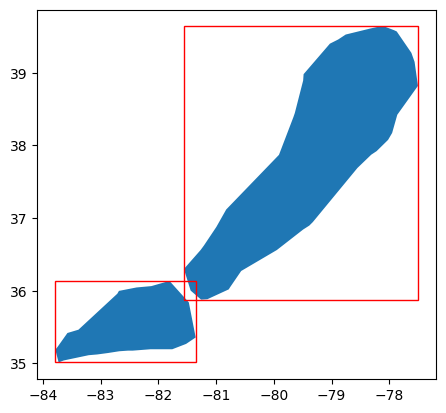

In [9]:
# Visualize polygons and bounding boxes
plot_bounds(gdf)

In [10]:
# Retrieve weather data, either cached or from Oikolabs
df = get_weather_data(gdf, '../data', 'oiko_easternmountain.csv')

In [11]:
# Show dataframe
df.head()

,latitude,longitude,time,temperature
0,36.0,-83.75,2015-01-01,-3.910004
1,36.0,-83.75,2015-01-02,4.029999
2,36.0,-83.75,2015-01-03,5.480011
3,36.0,-83.75,2015-01-04,9.230011
4,36.0,-83.75,2015-01-05,-2.119995
